In [248]:
#####Hierarchical Gaussian Process Regression model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns

#np.random.seed(98537)

In [249]:
###乱数を生成する関数を設定####
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

##多変量正規分布の乱数を生成する関数
def rmvnorm(mu, Cov, hh, k):
    s = mu + np.random.normal(0, 1, hh*k).reshape(hh, k)
    P = np.linalg.cholesky(Cov)
    y = np.dot(P, s.T).T
    return y

##任意の相関行列を作る関数
def CorM(col, lower, upper, eigen_lower, eigen_upper):
    #相関行列の初期値を定義する
    cov_vec = np.random.uniform(lower, upper, col*col)   #相関係数の乱数ベクトルを作成
    rho = np.tril(cov_vec.reshape(col, col), k=-1)   #乱数ベクトルを下三角行列化
    Sigma = (rho + rho.T) + np.diag(np.repeat(1, col))   #対角成分を1にする
    
    #相関行列を正定値行列に変更
    #固有値分解を実行
    eigen = np.linalg.eigh(Sigma)
    eigen_val = eigen[0] 
    eigen_vec = eigen[1]
    
    #固有値が負の数値を正にする
    for i in range(col):
        if eigen_val[i] < 0:
            eigen_val[i] = np.random.uniform(eigen_lower, eigen_upper, 1)
            
    #新しい相関行列の定義と対角成分を1にする
    Sigma = np.dot(np.dot(eigen_vec, np.diag(eigen_val)), eigen_vec.T)
    normalization_factor = np.dot(np.power(np.diag(Sigma), 0.5)[:, np.newaxis], np.power(np.diag(Sigma), 0.5)[np.newaxis, :])
    Cor = Sigma / normalization_factor
    return Cor

##相関行列から分散共分散行列に変換する関数
def covmatrix(Cor, sigma_lower, sigma_upper):
    sigma = (sigma_upper - sigma_lower) * rand(np.diag(Cor).shape[0]) + sigma_lower
    sigma_factor = np.dot(sigma[:, np.newaxis], sigma[np.newaxis, :])
    Cov = Cor * sigma_factor
    return Cov

##分散共分散行列から相関行列に変換する関数
def cov2cor(Cov):
    D = np.diag(np.power(np.diag(Cov), -1/2))
    corr = np.dot(np.dot(D, Cov), D)
    return corr

(array([ 17.,  53., 155., 255., 515., 563., 565., 544., 622., 458., 355.,
        264., 237., 135.,  80.,  56.,  45.,  32.,  21.,   9.,   8.,   4.,
          2.,   2.,   3.]),
 array([  6.  ,  10.24,  14.48,  18.72,  22.96,  27.2 ,  31.44,  35.68,
         39.92,  44.16,  48.4 ,  52.64,  56.88,  61.12,  65.36,  69.6 ,
         73.84,  78.08,  82.32,  86.56,  90.8 ,  95.04,  99.28, 103.52,
        107.76, 112.  ]),
 <a list of 25 Patch objects>)

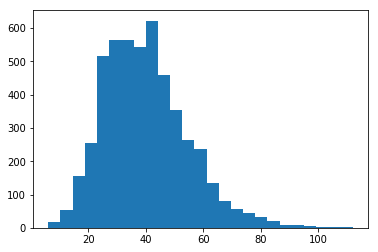

In [250]:
####データの発生####
##データの設定
type_n = 3
hh = 5000
pt = np.random.poisson(np.random.gamma(10.0, 1/0.25, hh), hh)
pt[pt <= 5] = 5
hhpt = np.sum(pt)
plt.hist(pt, bins=25)

In [251]:
##IDとインデックスを作成
#IDの作成
user_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスの設定
index = np.array(range(hhpt))
user_list = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
user_dt = sparse.coo_matrix((np.repeat(1, hhpt), (user_id, range(hhpt))), shape=(hh, hhpt)).tocsr()   #スパース行列の設定

In [252]:
##説明変数の生成
##素性ベクトルを生成
k1 = 4; k2 = 5; k3 = 4
x1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
x2 = np.zeros((hhpt, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, hhpt)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.concatenate((np.repeat(1, hhpt)[:, np.newaxis], x1, x2, x3), axis=1)
x_col = x.shape[1]

In [253]:
##階層モデルのカーネルを生成
#データとパラメータの設定
k = 20
v = 350
w = np.random.poisson(np.random.gamma(10, 1/0.2, hh), hh)
theta = np.random.dirichlet(np.repeat(0.2, k), hh)
phi = np.random.dirichlet(np.repeat(0.1, v), k)

#データの生成
W = np.array(np.zeros((hh, v)), dtype="int")
for i in range(hh):
    Z = np.random.multinomial(1, theta[i, ], w[i])
    z_vec = np.dot(Z, np.arange(k))
    W[i, ] = np.array(np.sum(np.array(rmnom(phi[z_vec, ], w[i], v, np.arange(w[i])).todense()), axis=0) > 0, dtype="int")
    
#カーネルの設定
K = cov2cor(np.dot(W, W.T))

In [255]:
##応答変数を生成
#パラメータを生成
mu = np.append(-1.0, np.repeat(0, k-1))
tau = np.append(4.5, np.random.uniform(1.5, 4.5, k-1))
theta = np.zeros((hh, x_col))
for j in range(x_col):
    print(j)
    theta[:, j] = np.random.multivariate_normal(np.repeat(mu[j], hh), tau[j]*K, 1)

#ロジスティック回帰モデルから応答変数を生成
logit = np.dot(x * theta[user_id, ], np.repeat(1, x_col))
Prob = np.exp(logit) / (1 + np.exp(logit))
y = np.random.binomial(1, Prob, hhpt)
y_vec = y[:, np.newaxis]

0
1
2
3
4
5
6
7
8
9
10
11
12


0.407365668950595


(array([58925., 13056.,  8516.,  6534.,  5284.,  4648.,  4125.,  3901.,
         3570.,  3444.,  3243.,  3191.,  3071.,  3124.,  3149.,  3151.,
         3283.,  3346.,  3582.,  4054.,  4492.,  5110.,  6477.,  9167.,
        29213.]),
 array([6.16494428e-10, 4.00000004e-02, 8.00000002e-02, 1.20000000e-01,
        1.60000000e-01, 2.00000000e-01, 2.39999999e-01, 2.79999999e-01,
        3.19999999e-01, 3.59999999e-01, 3.99999999e-01, 4.39999998e-01,
        4.79999998e-01, 5.19999998e-01, 5.59999998e-01, 5.99999998e-01,
        6.39999997e-01, 6.79999997e-01, 7.19999997e-01, 7.59999997e-01,
        7.99999997e-01, 8.39999996e-01, 8.79999996e-01, 9.19999996e-01,
        9.59999996e-01, 9.99999996e-01]),
 <a list of 25 Patch objects>)

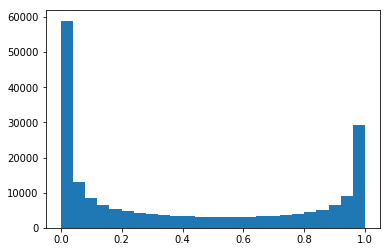

In [256]:
#データの確認
print(np.mean(y))
plt.hist(Prob, bins=25)

In [262]:
####マルコフ連鎖モンテカルロ法でモデルを推定####
##アルゴリズムの設定
R = 2000
keep = 4
burnin = int(500/keep)
iter = 0
disp = 10
e = 0.01
L = 3

In [264]:
##パラメータ推定のための関数を定義
#対数事後分布を計算する関数
def loglike(theta, y, X, u_mu, inv_Cov, user_id, user_dt, hhpt, k): 
    #ロジットモデルの対数尤度
    mu = np.exp(np.dot(X * theta[user_id, ], np.repeat(1, k)))   #ロジットの指数変換
    Prob = mu / (1 + mu)   
    LLi_logit = y*np.log(Prob) + (1-y)*np.log(1-Prob)   #ロジットモデルの対数尤度

    #多変量正規分布の対数尤度
    er = theta - u_mu   #パラメータの誤差
    LLi_mvn = -1/2 * np.dot(np.dot(er, inv_Cov) * er, np.repeat(1, k))

    #ユーザーごとの対数事後分布
    LLi = np.array(np.dot(user_dt, sparse.csc_matrix(LLi_logit.reshape(hhpt, 1))).todense()).reshape(-1) + LLi_mvn
    return LLi

#対数事後分布の微分関数
def dloglike(theta, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k):
    #ロジットモデルの対数尤度
    mu = np.exp(np.dot(X * theta[user_id, ], np.repeat(1, k)))   #ロジットの指数変換
    Prob = mu / (1 + mu)   

    #微分関数の設定
    er = theta - u_mu   #パラメータの誤差
    dlogit = y.reshape(hhpt, 1)*X - Prob.reshape(hhpt, 1)*X   #ロジスティック回帰の対数尤度の微分関数
    dmvn = -np.dot(inv_Cov, er.T).T   #多変量正規分布の対数事前分布の微分関数

    #勾配ベクトルの設定
    dlogit_sums = np.zeros((hh, k))
    for i in range(hh):
        dlogit_sums[i, ] = np.sum(dlogit[user_list[i], ], axis=0)
    LLd = -(dlogit_sums + dmvn)
    return LLd

##リープフロッグ法を解く関数
def leapfrog(r, z, D, e, L): 
    def leapfrog_step(r, z, e):
        r2 = r - e * D(z, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k) / 2
        z2 = z + e * r2
        r2 = r2 - e * D(z2, y, X, u_mu, inv_Cov, user_id, user_list, hhpt, k) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result